## LSTM Classifier

Testing if GPU activated

In [1]:
import tensorflow as tf
len(tf.config.experimental.list_physical_devices('GPU'))

2024-10-13 13:54:46.740945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 13:54:46.900787: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-13 13:54:46.969836: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 13:54:47.585513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

1

Doing the relevant imports

In [2]:
import pandas as pd
import numpy as np
# from tqdm.notebook import tqdm
from tqdm import tqdm
import ast
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint


Code to change progress bar color to dark from tqdm.

In [4]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  

Configuring the GPU

In [3]:
# GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use GPU 0
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2024-10-13 13:54:52.442175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 13:54:52.444155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 13:54:52.444188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 13:54:52.444200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been bu

Loading the dataset

In [5]:
tqdm.pandas()
# Just a facy way of loading the data while being able to see the rows being loaded in real time. 
# Each value is in chunk size of 1000. So 2,471 chunks = 2,471,000 rows.
df = pd.DataFrame(pd.concat([chunk for chunk in tqdm(pd.read_csv('../data/reddit_depression_dataset_cleaned.csv', chunksize=1000, index_col=0), desc='Loading data')]))
df.head()

Loading data: 1988it [00:33, 58.63it/s]


label                 date  upvotes  num_comments  \
0    0.0  2014-07-14 03:35:09      4.0           0.0   
1    0.0  2014-09-13 00:31:19      4.0           1.0   
2    0.0  2014-11-20 04:31:58      6.0           1.0   
3    0.0  2014-11-20 19:38:05     25.0           2.0   
5    0.0  2014-11-22 19:17:39      8.0          23.0   

                                       combined_text  \
0  Deep thoughts underdog Only when we start cons...   
1  I like this sub, there's only two posts yet I ...   
2  Rebirth! Hello. \nI am the new guy in charge h...   
3  "I want to be like water. I want to slip throu...   
5  What is the limit of the knowledge and power a...   

                                      tokenized_text  \
0  ['deep', 'thoughts', 'underdog', 'only', 'when...   
1  ['i', 'like', 'this', 'sub', ',', "there's", '...   
2  ['rebirth', '!', 'hello', '.', 'i', 'am', 'the...   
3  ['"', 'i', 'want', 'to', 'be', 'like', 'water'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                                       alphanum_text  \
0  ['deep', 'thoughts', 'underdog', 'only', 'when...   
1  ['i', 'like', 'this', 'sub', 'only', 'two', 'p...   
2  ['rebirth', 'hello', 'i', 'am', 'the', 'new', ...   
3  ['i', 'want', 'to', 'be', 'like', 'water', 'i'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                               stopword_removed_text  \
0  ['deep', 'thoughts', 'underdog', 'start', '99'...   
1  ['posts', 'coming', 'human', 'morality', 'joke...   
2  ['rebirth', 'guy', 'charge', 'thegood', 'ofc',...   
3  ['water', 'slip', 'fingers', 'hold', 'ship', '...   
5  ['limit', 'knowledge', 'power', 'human', 'pers...   

                                        stemmed_text  \
0  ['deep', 'thought', 'underdog', 'start', '99',...   
1  ['post', 'come', 'human', 'moral', 'joke', 'lo...   
2  ['rebirth', 'guy', 'charg', 'thegood', 'ofc', ...   
3  ['water', 'slip', 'finger', 'hold', 'ship', 'm...   
5  ['limit', 'knowledg', 'power', 'human', 'perso...   

                   non_stopword_removed_stemmed_text  \
0  ['deep', 'thought', 'underdog', 'onli', 'when'...   
1  ['i', 'like', 'thi', 'sub', 'onli', 'two', 'po...   
2  ['rebirth', 'hello', 'i', 'am', 'the', 'new', ...   
3  ['i', 'want', 'to', 'be', 'like', 'water', 'i'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                               combined_stemmed_text  \
0  deep thought underdog start 99 underdog start ...   
1  post come human moral joke long abscenc hope d...   
2  rebirth guy charg thegood ofc bring weirdpinea...   
3         water slip finger hold ship michel william   
5     limit knowledg power human person infinit grow   

          combined_non_stopword_removed_stemmed_text  
0  deep thought underdog onli when we start consi...  
1  i like thi sub onli two post yet i keep come b...  
2  rebirth hello i am the new guy in charg here b...  
3  i want to be like water i want to slip through...  
5  what is the limit of the knowledg and power a ...

In [6]:
df.shape

(1987011, 12)

In [7]:
df['label'].unique()

array([0., 1.])

There are two main labels: `0` and `1`.

In [8]:
print(df[df['label'] == 0].shape)
print(df[df['label'] == 1].shape)

(1761649, 12)
(225362, 12)


### Data Processing

In [9]:
df.isnull().sum()

label                                             0
date                                              0
upvotes                                           0
num_comments                                      0
combined_text                                     0
tokenized_text                                    0
alphanum_text                                     0
stopword_removed_text                             0
stemmed_text                                      0
non_stopword_removed_stemmed_text                 0
combined_stemmed_text                         12190
combined_non_stopword_removed_stemmed_text     1046
dtype: int64

There are some missing values from the last two attributes.

In [10]:
df[df['combined_stemmed_text'].isnull()].head()

label                 date  upvotes  num_comments  \
314     0.0  2017-02-06 05:02:10      4.0           9.0   
526     0.0  2017-12-05 11:54:57      4.0           5.0   
999     0.0  2018-11-28 02:11:29      9.0           6.0   
1425    0.0  2019-05-28 10:55:26     11.0           5.0   
1906    0.0  2019-12-02 04:24:03      6.0           5.0   

                                          combined_text  \
314                 You have to be there to know there    
526   become one with what you want to get to where ...   
999    Everything is nothing if nothing is everything?    
1425  Do we actually know anyone? No one ever hardly...   
1906                             I am not who I am yet    

                                         tokenized_text  \
314   ['you', 'have', 'to', 'be', 'there', 'to', 'kn...   
526   ['become', 'one', 'with', 'what', 'you', 'want...   
999   ['everything', 'is', 'nothing', 'if', 'nothing...   
1425  ['do', 'we', 'actually', 'know', 'anyone', '?'...   
1906        ['i', 'am', 'not', 'who', 'i', 'am', 'yet']   

                                          alphanum_text stopword_removed_text  \
314   ['you', 'have', 'to', 'be', 'there', 'to', 'kn...                    []   
526   ['become', 'one', 'with', 'what', 'you', 'want...                    []   
999   ['everything', 'is', 'nothing', 'if', 'nothing...                    []   
1425  ['do', 'we', 'actually', 'know', 'anyone', 'no...                    []   
1906        ['i', 'am', 'not', 'who', 'i', 'am', 'yet']                    []   

     stemmed_text                  non_stopword_removed_stemmed_text  \
314            []  ['you', 'have', 'to', 'be', 'there', 'to', 'kn...   
526            []  ['becom', 'one', 'with', 'what', 'you', 'want'...   
999            []  ['everyth', 'is', 'noth', 'if', 'noth', 'is', ...   
1425           []  ['do', 'we', 'actual', 'know', 'anyon', 'no', ...   
1906           []        ['i', 'am', 'not', 'who', 'i', 'am', 'yet']   

     combined_stemmed_text         combined_non_stopword_removed_stemmed_text  
314                    NaN                 you have to be there to know there  
526                    NaN  becom one with what you want to get to where y...  
999                    NaN                 everyth is noth if noth is everyth  
1425                   NaN  do we actual know anyon no one ever hardli sho...  
1906                   NaN                              i am not who i am yet

Upon further investigation, we can see that the text processing has deemed all its contents to be overly high frequency, and ended up omitting the entire text.

In [11]:
df = df.dropna(subset=['combined_stemmed_text'])
df.isnull().sum()

label                                         0
date                                          0
upvotes                                       0
num_comments                                  0
combined_text                                 0
tokenized_text                                0
alphanum_text                                 0
stopword_removed_text                         0
stemmed_text                                  0
non_stopword_removed_stemmed_text             0
combined_stemmed_text                         0
combined_non_stopword_removed_stemmed_text    0
dtype: int64

In cases like this, we can remove the rows that do not help us for this classification task.

In [12]:
print('Date:', type(df['date'][0]))
print('Upvotes:', type(df['upvotes'][0]))
print('Num Comments:', type(df['num_comments'][0]))
print('Stemmed Text:', type(df['stemmed_text'][0]))

Date: <class 'str'>
Upvotes: <class 'numpy.float64'>
Num Comments: <class 'numpy.float64'>
Stemmed Text: <class 'str'>


The two main attributes that need type conversions are `date` and `stemmed_text`.

In [13]:
df['date'] = pd.to_datetime(df['date'])
type(df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [14]:
df['stemmed_text'] = df['stemmed_text'].progress_apply(ast.literal_eval)
type(df['stemmed_text'][0])

100%|██████████| 1974821/1974821 [00:21<00:00, 91288.49it/s] 


list

In [15]:
df.head()

label                date  upvotes  num_comments  \
0    0.0 2014-07-14 03:35:09      4.0           0.0   
1    0.0 2014-09-13 00:31:19      4.0           1.0   
2    0.0 2014-11-20 04:31:58      6.0           1.0   
3    0.0 2014-11-20 19:38:05     25.0           2.0   
5    0.0 2014-11-22 19:17:39      8.0          23.0   

                                       combined_text  \
0  Deep thoughts underdog Only when we start cons...   
1  I like this sub, there's only two posts yet I ...   
2  Rebirth! Hello. \nI am the new guy in charge h...   
3  "I want to be like water. I want to slip throu...   
5  What is the limit of the knowledge and power a...   

                                      tokenized_text  \
0  ['deep', 'thoughts', 'underdog', 'only', 'when...   
1  ['i', 'like', 'this', 'sub', ',', "there's", '...   
2  ['rebirth', '!', 'hello', '.', 'i', 'am', 'the...   
3  ['"', 'i', 'want', 'to', 'be', 'like', 'water'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                                       alphanum_text  \
0  ['deep', 'thoughts', 'underdog', 'only', 'when...   
1  ['i', 'like', 'this', 'sub', 'only', 'two', 'p...   
2  ['rebirth', 'hello', 'i', 'am', 'the', 'new', ...   
3  ['i', 'want', 'to', 'be', 'like', 'water', 'i'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                               stopword_removed_text  \
0  ['deep', 'thoughts', 'underdog', 'start', '99'...   
1  ['posts', 'coming', 'human', 'morality', 'joke...   
2  ['rebirth', 'guy', 'charge', 'thegood', 'ofc',...   
3  ['water', 'slip', 'fingers', 'hold', 'ship', '...   
5  ['limit', 'knowledge', 'power', 'human', 'pers...   

                                        stemmed_text  \
0  [deep, thought, underdog, start, 99, underdog,...   
1  [post, come, human, moral, joke, long, abscenc...   
2  [rebirth, guy, charg, thegood, ofc, bring, wei...   
3  [water, slip, finger, hold, ship, michel, will...   
5  [limit, knowledg, power, human, person, infini...   

                   non_stopword_removed_stemmed_text  \
0  ['deep', 'thought', 'underdog', 'onli', 'when'...   
1  ['i', 'like', 'thi', 'sub', 'onli', 'two', 'po...   
2  ['rebirth', 'hello', 'i', 'am', 'the', 'new', ...   
3  ['i', 'want', 'to', 'be', 'like', 'water', 'i'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                               combined_stemmed_text  \
0  deep thought underdog start 99 underdog start ...   
1  post come human moral joke long abscenc hope d...   
2  rebirth guy charg thegood ofc bring weirdpinea...   
3         water slip finger hold ship michel william   
5     limit knowledg power human person infinit grow   

          combined_non_stopword_removed_stemmed_text  
0  deep thought underdog onli when we start consi...  
1  i like thi sub onli two post yet i keep come b...  
2  rebirth hello i am the new guy in charg here b...  
3  i want to be like water i want to slip through...  
5  what is the limit of the knowledg and power a ...

100%|██████████| 1974821/1974821 [00:00<00:00, 2679108.46it/s]


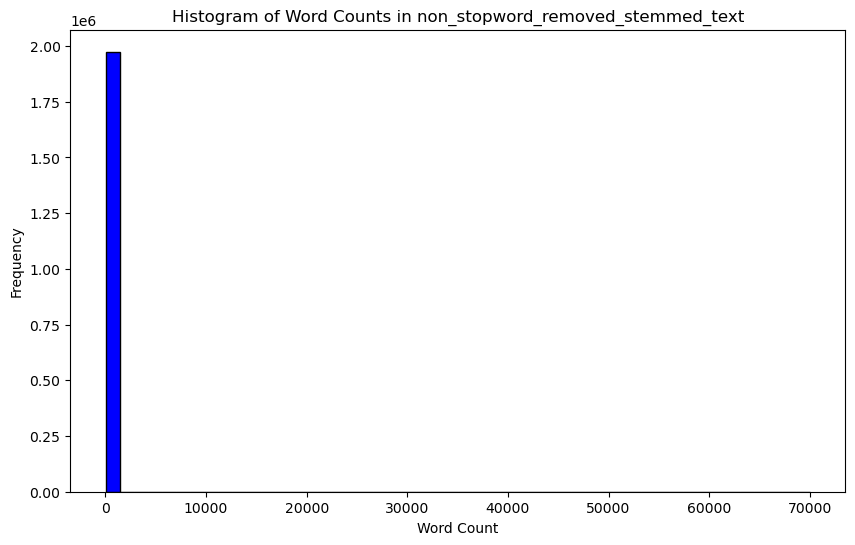

In [16]:
# Calculate the word counts for each row in 'non_stopword_removed_stemmed_text'
word_counts = df['non_stopword_removed_stemmed_text'].progress_apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Word Counts in non_stopword_removed_stemmed_text')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Calculate the 80th percentile of word counts
percentile_80 = word_counts.quantile(0.80)

# Filter the dataframe to keep only rows with word counts less than or equal to the 80th percentile
df_non = df[word_counts <= percentile_80]

# Display the shape of the filtered dataframe
print(df_non.shape)

(1580321, 12)


100%|██████████| 1580321/1580321 [00:00<00:00, 2731606.38it/s]


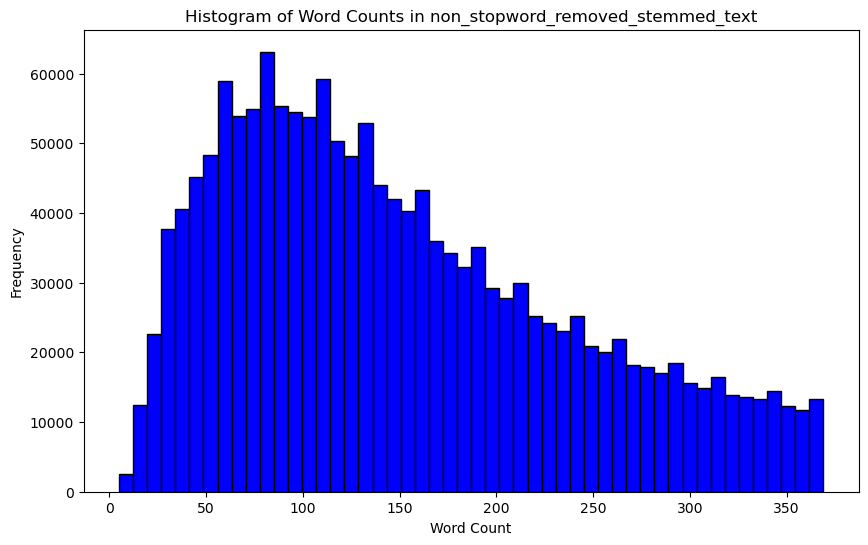

In [18]:
# Calculate the word counts for each row in 'non_stopword_removed_stemmed_text'
filtered_word_counts = df_non['non_stopword_removed_stemmed_text'].progress_apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_word_counts, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Word Counts in non_stopword_removed_stemmed_text')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

### Model 6: Final Model used
Uses a single LSTM layer and a single logistic regression layer

Prep for non_stopword_removed_stemmed_text

In [25]:
df_non['non_stopword_removed_stemmed_text'] = df_non['non_stopword_removed_stemmed_text'].progress_apply(ast.literal_eval)
type(df_non['non_stopword_removed_stemmed_text'][0])

100%|██████████| 1580321/1580321 [00:29<00:00, 52821.14it/s]
/tmp/ipykernel_100926/541584140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non['non_stopword_removed_stemmed_text'] = df_non['non_stopword_removed_stemmed_text'].progress_apply(ast.literal_eval)


list

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_non['non_stopword_removed_stemmed_text'])
print(tokenizer.word_index)

{'i': 1, 'to': 2, 'a': 3, 'the': 4, 'and': 5, 'my': 6, 'you': 7, 'it': 8, 'is': 9, 'of': 10, 'me': 11, 'in': 12, 'just': 13, 'for': 14, 'thi': 15, 'have': 16, 'that': 17, 'do': 18, 'like': 19, 'so': 20, 'on': 21, 'be': 22, 'but': 23, 'what': 24, 'are': 25, 'with': 26, 'get': 27, 'if': 28, 'your': 29, 'all': 30, 'not': 31, 'wa': 32, 'want': 33, 'can': 34, 'how': 35, 's': 36, 'or': 37, 'm': 38, 'fuck': 39, 'guy': 40, 'go': 41, 'day': 42, 't': 43, 'about': 44, 'at': 45, 'out': 46, 'feel': 47, 'know': 48, 'peopl': 49, 'up': 50, 'now': 51, 'when': 52, 'one': 53, 'post': 54, 'am': 55, 'no': 56, 'whi': 57, 'make': 58, 'girl': 59, 'we': 60, 'got': 61, 'time': 62, 'think': 63, 'they': 64, 'friend': 65, 'some': 66, 'who': 67, 'an': 68, 'school': 69, 'good': 70, 'say': 71, 'as': 72, 'anyon': 73, 'im': 74, 'realli': 75, 'from': 76, 'need': 77, 'she': 78, 'here': 79, 'help': 80, 'year': 81, 'will': 82, 'someon': 83, 'becaus': 84, 'talk': 85, 'today': 86, 'ask': 87, 'there': 88, 'would': 89, 'thing'

In [27]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)

Vocabulary Size: 156298


In [29]:
sequences = tokenizer.texts_to_sequences(df_non['non_stopword_removed_stemmed_text'])
max_length = max(len(seq) for seq in sequences)
print('Longest Sequence:', max_length)

Longest Sequence: 66


In [30]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print('Padded Sequences Shape:', padded_sequences.shape)

Padded Sequences Shape: (1580321, 66)


In [32]:
X = padded_sequences
y = df_non['label']
print(X.shape, y.shape)

(1580321, 66) (1580321,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1264256, 66) (1264256,)
(316065, 66) (316065,)


In [34]:
with tf.device('/GPU:0'):
    model6 = Sequential()
    model6.add(layers.Embedding(vocab_size, 32))
    model6.add(LSTM(40,dropout=0.5))
    model6.add(Dense(1,activation='sigmoid'))

    model6.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('../data/LSTM6_model_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

    model6.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5


2024-10-12 23:16:48.452100: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-10-12 23:16:49.937053: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


39508/39508 [==============================] - 334s 8ms/step - loss: 0.1147 - accuracy: 0.9591 - val_loss: 0.0989 - val_accuracy: 0.9637
Epoch 2/5
39508/39508 [==============================] - 339s 9ms/step - loss: 0.0982 - accuracy: 0.9636 - val_loss: 0.0963 - val_accuracy: 0.9647
Epoch 3/5
39508/39508 [==============================] - 327s 8ms/step - loss: 0.0950 - accuracy: 0.9648 - val_loss: 0.0946 - val_accuracy: 0.9654
Epoch 4/5
39508/39508 [==============================] - 330s 8ms/step - loss: 0.0926 - accuracy: 0.9658 - val_loss: 0.0937 - val_accuracy: 0.9656
Epoch 5/5
39508/39508 [==============================] - 336s 8ms/step - loss: 0.0911 - accuracy: 0.9664 - val_loss: 0.0941 - val_accuracy: 0.9656


In [35]:
test_loss, test_accuracy = model6.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

9878/9878 [==============================] - 42s 4ms/step - loss: 0.0941 - accuracy: 0.9656
Test accuracy: 0.9656


9878/9878 [==============================] - 27s 3ms/step


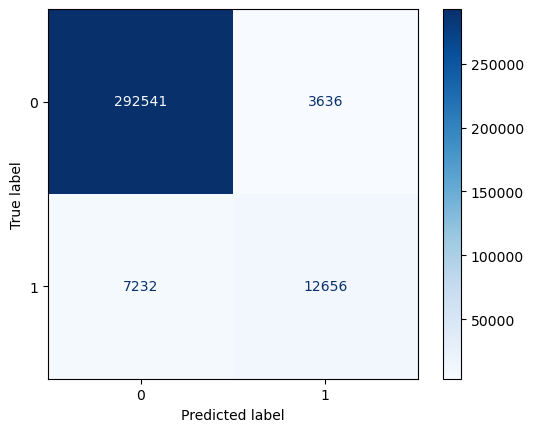

In [36]:
# Predict the labels for the test set
y_pred = (model6.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

Accuracy Score: 0.9656
F1 Score: 0.6996


### Model Building for all the draft models

Prep for stemmed_text

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['stemmed_text'])
print(tokenizer.word_index)

{'feel': 1, 'peopl': 2, 'fuck': 3, 'day': 4, 'friend': 5, 'guy': 6, 'time': 7, 'girl': 8, 'post': 9, 'school': 10, 'talk': 11, 'life': 12, 'year': 13, 'thing': 14, 'good': 15, 'love': 16, 'today': 17, 'shit': 18, 'depress': 19, 'start': 20, 'hate': 21, 'happi': 22, 'die': 23, 'live': 24, 'person': 25, 'wanna': 26, 'bad': 27, 'thought': 28, 'work': 29, 'crush': 30, 'gonna': 31, 'play': 32, 'reddit': 33, '2': 34, 'sleep': 35, 'kill': 36, 'care': 37, 'edit': 38, 'parent': 39, 'sad': 40, 'dont': 41, 'hour': 42, 'game': 43, 'filler': 44, 'class': 45, 'teenag': 46, 'watch': 47, 'mom': 48, 'week': 49, 'comment': 50, 'lot': 51, 'want': 52, 'happen': 53, 'suicid': 54, 'month': 55, 'hope': 56, 'meme': 57, 'told': 58, 'pretti': 59, 'night': 60, '3': 61, 'bore': 62, 'final': 63, 'song': 64, 'hey': 65, 'long': 66, 'question': 67, 'ask': 68, 'kid': 69, 'boy': 70, 'turn': 71, 'idk': 72, 'think': 73, 'reason': 74, 'hard': 75, 'listen': 76, 'stuff': 77, 'nice': 78, 'famili': 79, 'tire': 80, 'girlfriend

In [17]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)

Vocabulary Size: 190287


In [18]:
sequences = tokenizer.texts_to_sequences(df['stemmed_text'])
max_length = max(len(seq) for seq in sequences)
print('Longest Sequence:', max_length)

Longest Sequence: 32


In [19]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print('Padded Sequences Shape:', padded_sequences.shape)

Padded Sequences Shape: (1974821, 32)


In [20]:
X = padded_sequences
y = df['label']
print(X.shape, y.shape)

(1974821, 32) (1974821,)


In [21]:
X[0]

array([  578,    28, 16858,    20,  1841, 16858,    20,  2522,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(1579856, 32) (1579856,)
(394965, 32) (394965,)


### Model Building

Model 1: using a single LSTM layer

In [42]:
with tf.device('/GPU:0'):
    model1 = Sequential()
    model1.add(layers.Embedding(vocab_size, 32))
    model1.add(LSTM(40,dropout=0.5))
    model1.add(Dense(1,activation='sigmoid'))

    model1.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('../data/LSTM1_model_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

    model1.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5
49371/49371 [==============================] - 410s 8ms/step - loss: 0.1443 - accuracy: 0.9447 - val_loss: 0.1337 - val_accuracy: 0.9481
Epoch 2/5
49371/49371 [==============================] - 419s 8ms/step - loss: 0.1333 - accuracy: 0.9484 - val_loss: 0.1319 - val_accuracy: 0.9493
Epoch 3/5
49371/49371 [==============================] - 415s 8ms/step - loss: 0.1298 - accuracy: 0.9498 - val_loss: 0.1296 - val_accuracy: 0.9501
Epoch 4/5
49371/49371 [==============================] - 390s 8ms/step - loss: 0.1278 - accuracy: 0.9506 - val_loss: 0.1301 - val_accuracy: 0.9492
Epoch 5/5
49371/49371 [==============================] - 399s 8ms/step - loss: 0.1263 - accuracy: 0.9510 - val_loss: 0.1294 - val_accuracy: 0.9504


In [43]:
test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

12343/12343 [==============================] - 42s 3ms/step - loss: 0.1294 - accuracy: 0.9504
Test accuracy: 0.9504


In [44]:
print('Actual:', y[y==0][:5].values)
print('Predicted/Classified:', model1.predict(X[:5]))

Actual: [0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 238ms/step
Predicted/Classified: [[0.02385109]
 [0.05798572]
 [0.00453471]
 [0.00149467]
 [0.00334378]]


In [45]:
print('Actual:', y[y==1][:5].values)
print('Predicted/Classified:', model1.predict(X[-5:]))

Actual: [1. 1. 1. 1. 1.]
1/1 [==============================] - 0s 18ms/step
Predicted/Classified: [[0.17371915]
 [0.68366414]
 [0.61941457]
 [0.34065345]
 [0.0075204 ]]


12343/12343 [==============================] - 28s 2ms/step


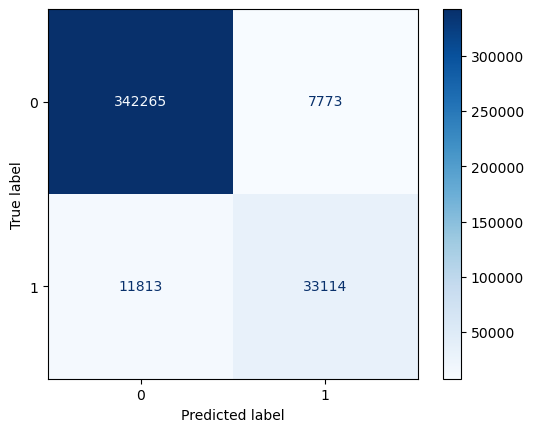

In [46]:
# Predict the labels for the test set
y_pred = (model1.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [47]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

Accuracy Score: 0.9504
F1 Score: 0.7718


Model 2: using 2 LSTM layer

In [48]:
model2 = Sequential()
model2.add(layers.Embedding(vocab_size, 16))
model2.add(LSTM(40,dropout=0.5, return_sequences=True))
model2.add(LSTM(40,dropout=0.5))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('../data/LSTM2_model_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5
49371/49371 [==============================] - 506s 10ms/step - loss: 0.1475 - accuracy: 0.9438 - val_loss: 0.1373 - val_accuracy: 0.9471
Epoch 2/5
49371/49371 [==============================] - 475s 10ms/step - loss: 0.1365 - accuracy: 0.9472 - val_loss: 0.1339 - val_accuracy: 0.9486
Epoch 3/5
49371/49371 [==============================] - 496s 10ms/step - loss: 0.1339 - accuracy: 0.9483 - val_loss: 0.1394 - val_accuracy: 0.9479
Epoch 4/5
49371/49371 [==============================] - 510s 10ms/step - loss: 0.1320 - accuracy: 0.9490 - val_loss: 0.1430 - val_accuracy: 0.9463
Epoch 5/5
49371/49371 [==============================] - 503s 10ms/step - loss: 0.1308 - accuracy: 0.9495 - val_loss: 0.1548 - val_accuracy: 0.9412


In [50]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

12343/12343 [==============================] - 59s 5ms/step - loss: 0.1548 - accuracy: 0.9412
Test accuracy: 0.9412


In [51]:
print('Actual:', y[y==0][:5].values)
print('Predicted/Classified:', model2.predict(X[:5]))

Actual: [0. 0. 0. 0. 0.]
1/1 [==============================] - 1s 649ms/step
Predicted/Classified: [[0.12277807]
 [0.21158615]
 [0.09043794]
 [0.02138047]
 [0.01495571]]


In [52]:
print('Actual:', y[y==1][:5].values)
print('Predicted/Classified:', model2.predict(X[-5:]))

Actual: [1. 1. 1. 1. 1.]
1/1 [==============================] - 0s 23ms/step
Predicted/Classified: [[0.6902935 ]
 [0.7871282 ]
 [0.83067435]
 [0.43545192]
 [0.03569679]]


12343/12343 [==============================] - 41s 3ms/step


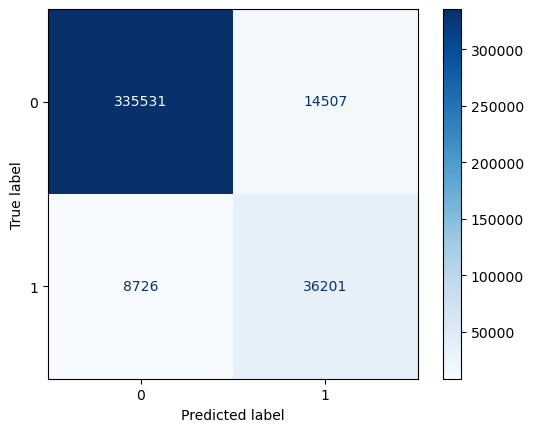

In [53]:
# Predict the labels for the test set
y_pred = (model2.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [54]:
accuracy_model2 = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy_model2:.4f}")
f1_model2 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_model2:.4f}")

Accuracy Score: 0.9412
F1 Score: 0.7571


Model 3: fine tuned parameters

In [ ]:
model3 = Sequential()
model3.add(layers.Embedding(vocab_size, 40))
model3.add(LSTM(64,dropout=0.3, return_sequences=True))
model3.add(LSTM(64,dropout=0.3))
model3.add(Dense(1,activation='sigmoid'))

model3.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('../data/LSTM3_model_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

model3.fit(X_train, y_train, epochs=2,validation_data=(X_test, y_test))

In [ ]:
test_loss, test_accuracy = model3.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

In [ ]:
print('Actual:', y[y==0][:5].values)
print('Predicted/Classified:', model3.predict(X[:5]))

In [ ]:
print('Actual:', y[y==1][:5].values)
print('Predicted/Classified:', model3.predict(X[-5:]))

In [ ]:
# Predict the labels for the test set
y_pred = (model3.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
accuracy_model3 = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy_model3:.4f}")
f1_model3 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_model3:.4f}")

Model 4: fine tuned using bidirectional layers

In [ ]:
model4 = Sequential()
model4.add(layers.Embedding(vocab_size, 40))
model4.add(layers.Bidirectional(LSTM(64,dropout=0.3, return_sequences=True)))
model4.add(layers.Bidirectional(LSTM(64,dropout=0.3)))
model4.add(Dense(1,activation='sigmoid'))

model4.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('../data/LSTM4_model_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

model4.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test))

In [ ]:
test_loss, test_accuracy = model4.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

In [ ]:
print('Actual:', y[y==0][:5].values)
print('Predicted/Classified:', model4.predict(X[:5]))

In [ ]:
print('Actual:', y[y==1][:5].values)
print('Predicted/Classified:', model4.predict(X[-5:]))

In [ ]:
# Predict the labels for the test set
y_pred = (model4.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
accuracy_model4 = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy_model4:.4f}")
f1_model4 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_model4:.4f}")

Model 5: OverSampling

In [31]:
# Reset the index of both X_train and y_train
X_train_reset = pd.DataFrame(X_train).reset_index(drop=True)
y_train_reset = pd.DataFrame(y_train, columns=['label']).reset_index(drop=True)

# Now concatenate them
X_sampling = pd.concat([X_train_reset, y_train_reset], axis=1)

# Print to verify
print(X_sampling.head())

(1579856, 32) (1579856,)
(394965, 32) (394965,)
     0     1      2      3    4     5     6     7      8     9  ...  23  24  \
0   92  4887  10250  12394   38  6157     0     0      0     0  ...   0   0   
1    9  2317     89      4  551   366   233  4931  18567     0  ...   0   0   
2  287   532    243   1603    2   434  1825   299   3089   207  ...   0   0   
3  204   330   2432     76  171    64   188   197    275  6769  ...   0   0   
4  404   451      0      0    0     0     0     0      0     0  ...   0   0   

   25  26  27  28  29  30  31  label  
0   0   0   0   0   0   0   0    0.0  
1   0   0   0   0   0   0   0    0.0  
2   0   0   0   0   0   0   0    0.0  
3   0   0   0   0   0   0   0    0.0  
4   0   0   0   0   0   0   0    0.0  

[5 rows x 33 columns]


In [34]:
depressed = X_sampling[X_sampling['label'] == 1]
not_depressed = X_sampling[X_sampling['label'] == 0]

print(depressed.shape, not_depressed.shape)

(179707, 33) (1400149, 33)


In [35]:
depressed_upsampled = resample(depressed,
                    replace=True, # sample with replacement
                    n_samples=round(len(not_depressed)*0.8), # match number in majority class
                    random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_depressed, depressed_upsampled])
print (upsampled.label.value_counts())

label
0.0    1400149
1.0    1120119
Name: count, dtype: int64


In [36]:
upsampled_X_train = upsampled.drop('label', axis=1)
upsampled_y_train = upsampled['label']
print(upsampled_X_train.head())
upsampled_X_train = upsampled_X_train.to_numpy()



    0     1      2      3    4     5     6     7      8     9   ...  22  23  \
0   92  4887  10250  12394   38  6157     0     0      0     0  ...   0   0   
1    9  2317     89      4  551   366   233  4931  18567     0  ...   0   0   
2  287   532    243   1603    2   434  1825   299   3089   207  ...   0   0   
3  204   330   2432     76  171    64   188   197    275  6769  ...   0   0   
4  404   451      0      0    0     0     0     0      0     0  ...   0   0   

   24  25  26  27  28  29  30  31  
0   0   0   0   0   0   0   0   0  
1   0   0   0   0   0   0   0   0  
2   0   0   0   0   0   0   0   0  
3   0   0   0   0   0   0   0   0  
4   0   0   0   0   0   0   0   0  

[5 rows x 32 columns]


In [37]:
with tf.device('/GPU:0'):
    model5 = Sequential()
    model5.add(layers.Embedding(vocab_size, 32))
    model5.add(LSTM(40,dropout=0.5))
    model5.add(Dense(1,activation='sigmoid'))

    model5.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint('../data/LSTM5_model_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

    model5.fit(upsampled_X_train, upsampled_y_train, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5
78759/78759 [==============================] - 592s 8ms/step - loss: 0.2260 - accuracy: 0.9093 - val_loss: 0.1975 - val_accuracy: 0.9154
Epoch 2/5
78759/78759 [==============================] - 581s 7ms/step - loss: 0.2034 - accuracy: 0.9190 - val_loss: 0.1906 - val_accuracy: 0.9233
Epoch 3/5
78759/78759 [==============================] - 586s 7ms/step - loss: 0.1959 - accuracy: 0.9223 - val_loss: 0.2017 - val_accuracy: 0.9147
Epoch 4/5
78759/78759 [==============================] - 599s 8ms/step - loss: 0.1917 - accuracy: 0.9240 - val_loss: 0.1841 - val_accuracy: 0.9259
Epoch 5/5
78759/78759 [==============================] - 646s 8ms/step - loss: 0.1883 - accuracy: 0.9255 - val_loss: 0.1825 - val_accuracy: 0.9238


In [38]:
test_loss, test_accuracy = model5.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

12343/12343 [==============================] - 45s 4ms/step - loss: 0.1825 - accuracy: 0.9238
Test accuracy: 0.9238


12343/12343 [==============================] - 27s 2ms/step


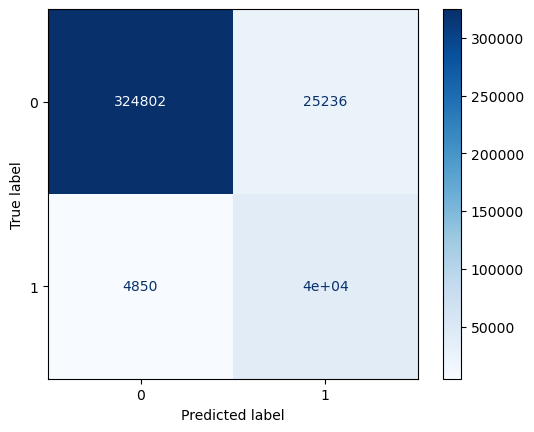

In [39]:
# Predict the labels for the test set
y_pred = (model5.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [40]:
accuracy_model5 = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy_model5:.4f}")
f1_model5 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_model5:.4f}")

Accuracy Score: 0.9238
F1 Score: 0.7271


Model 7: Using custom sigmoid loss function 

In [34]:
def custom_sigmoid_loss(neg_weight, pos_weight):
    """
    Custom loss function for a binary classification model with a sigmoid output.
    
    Args:
        neg_weight (float): Weight for the negative class (label 0).
        pos_weight (float): Weight for the positive class (label 1).
    
    Returns:
        A loss function that applies the appropriate weighting.
    """
    def loss(y_true, y_pred):
        # Clip y_pred to prevent log(0) issues, ensuring stability
        epsilon = tf.keras.backend.epsilon()  # A small value to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate binary cross-entropy loss
        bce_loss = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        
        # Apply weights: increase penalty for false negatives or false positives
        weights = tf.where(tf.equal(y_true, 1), pos_weight, neg_weight)
        weighted_loss = weights * bce_loss
        
        return tf.reduce_mean(weighted_loss)
    
    return loss

In [35]:
with tf.device('/GPU:0'):
    model7 = Sequential()
    model7.add(layers.Embedding(vocab_size, 32))
    model7.add(LSTM(40,dropout=0.5))
    model7.add(Dense(1,activation='sigmoid'))

    model7.compile(optimizer='adam',loss=custom_sigmoid_loss(1.0, 1.5), metrics=['accuracy'])

    checkpoint = ModelCheckpoint('../data/LSTM1_mode7_checkpoint.weights.h5', save_weights_only=True, save_best_only=False)

    model7.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))

Epoch 1/5
49371/49371 [==============================] - 352s 7ms/step - loss: 0.1843 - accuracy: 0.9430 - val_loss: 0.1715 - val_accuracy: 0.9482
Epoch 2/5
49371/49371 [==============================] - 345s 7ms/step - loss: 0.1697 - accuracy: 0.9469 - val_loss: 0.1664 - val_accuracy: 0.9490
Epoch 3/5
49371/49371 [==============================] - 344s 7ms/step - loss: 0.1650 - accuracy: 0.9483 - val_loss: 0.1638 - val_accuracy: 0.9491
Epoch 4/5
49371/49371 [==============================] - 344s 7ms/step - loss: 0.1621 - accuracy: 0.9492 - val_loss: 0.1645 - val_accuracy: 0.9472
Epoch 5/5
49371/49371 [==============================] - 345s 7ms/step - loss: 0.1603 - accuracy: 0.9496 - val_loss: 0.1653 - val_accuracy: 0.9460


In [36]:
test_loss, test_accuracy = model7.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

12343/12343 [==============================] - 36s 3ms/step - loss: 0.1653 - accuracy: 0.9460
Test accuracy: 0.9460


12343/12343 [==============================] - 23s 2ms/step


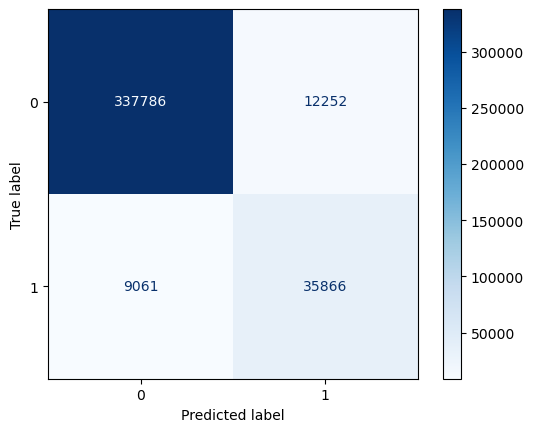

In [44]:
# Predict the labels for the test set
y_pred = (model7.predict(X_test) > 0.5).astype("int32")

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [45]:
accuracy_model2 = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy_model2:.4f}")
f1_model2 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1_model2:.4f}")

Accuracy Score: 0.9460
F1 Score: 0.7709
